In [1]:
# Loading NN-Benchmark model

import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(6, 256)
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, 1024)
        self.fc4 = nn.Linear(1024, 800)  # 800 = 400*2 (400 points, 2d)

    def forward(self, x):  # x are the states: [d_obs_x, d_obs_y, d_goal_x, d_goal_y]
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x


model_path = '/home/yigit/Documents/projects/irl_sfm/python_ws/nn_baseline_for_cnmp/model/nn_models/changing_s_g_model_traj_est_state_dict.pt'
benchmark_model = Net()
benchmark_model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [2]:
# small_env_changing_s_g contains discrete sources and goals
# must change this with new datasets
def create_test_configuration():
    sy, gy, ox, oy = 0.0, 13.0, 1.0, 6.0
    config = torch.zeros((20, 6))
    config[0,:] = torch.Tensor([0, sy, 0, gy, ox, oy])
    config[1,:] = torch.Tensor([0, sy, 2, gy, ox, oy])
    config[2,:] = torch.Tensor([0, sy, -2, gy, ox, oy])
    config[18,:] = torch.Tensor([2, sy, 0, gy, ox, oy])
    config[4,:] = torch.Tensor([2, sy, 2, gy, ox, oy])
    config[5,:] = torch.Tensor([2, sy, -2, gy, ox, oy])
    config[6,:] = torch.Tensor([-2, sy, 0, gy, ox, oy])
    config[7,:] = torch.Tensor([-2, sy, 2, gy, ox, oy])
    config[8,:] = torch.Tensor([-2, sy, -2, gy, ox, oy])
    
    config[19,:] = torch.Tensor([0, sy, 0, gy, 0, 10])
    config[14,:] = torch.Tensor([2, sy, 2, gy, 2, 3])
    config[13,:] = torch.Tensor([-2, sy, -2, gy, -2, 6.5])
    config[12,:] = torch.Tensor([-2, sy, 0, gy, -1, 8.5])
    config[11,:] = torch.Tensor([0, sy, 2, gy, 1, 4.5])
    config[10,:] = torch.Tensor([2, sy, -2, gy, 0, 6.5])
    config[15,:] = torch.Tensor([2, sy, 2, gy, 2, 9])
    config[16,:] = torch.Tensor([-2, sy, -2, gy, -2, 9.5])
    config[17,:] = torch.Tensor([0, sy, 0, gy, 0, 9])
    config[3,:] = torch.Tensor([0, sy, 0, gy, -0.1, 2.5])
    config[9,:] = torch.Tensor([2, sy, 2, gy, 2.1, 9.5])
    return config

In [3]:
# forward pass with test configurations
config = create_test_configuration()

trajs = benchmark_model(config)
num_trajs, points_xy = trajs.shape
trajs_coords = trajs.view((num_trajs, int(points_xy/2), 2))
trajs_coords = trajs_coords.detach()

------

##### CNMP

In [4]:
# This script loads trajectories generated by a pretrained CNMP model. This is not how I want to continue though,
# because this comparison is not fair. Cell below loads a new CNMP model (trained on timed trajectories). And this
# comparison is more fair

#####

# import os
# import numpy as np

# trajectories_path = '/home/yigit/phd/yigit_phd_thesis/cnmp/output/sfm/small_env_changing_s_g/1607473236/runs/'
# cnmp_trajectories = {}
# for filename in os.listdir(trajectories_path):
#     if filename.endswith(".npy"):
#         filepath = os.path.join(trajectories_path, filename)
#         test_num = int(filename.replace('.npy', ''))
#         traj = np.load(filepath)
#         desired_len = 400
#         indices = np.linspace(0, len(traj)-10, desired_len, dtype=int)
#         cnmp_trajectories[test_num] = traj[indices][:, -2:]

In [5]:
# Loading CNMP timed-trajectories model

import numpy as np

from keras.models import Model, load_model
import keras.losses
import tensorflow as tf
import tensorflow_probability as tfp

from tqdm import tqdm


def custom_loss(y_true, y_predicted):
    mean, log_sigma = tf.split(y_predicted, 2, axis=-1)
    y_true_value, temp = tf.split(y_true, 2, axis=-1)
    sigma = tf.nn.softplus(log_sigma)
    dist = tfp.distributions.MultivariateNormalDiag(loc=mean, scale_diag=sigma)
    loss = -tf.reduce_mean(dist.log_prob(y_true_value))
    return loss

cnmp_root_path = f'/home/yigit/phd/yigit_phd_thesis/cnmp/output/sfm/small_env_changing_s_g/generate_trajectory/1620754718/'
cnmp_model_path = f'{cnmp_root_path}cnmp_best_validation.h5'

cnmp_model = load_model(cnmp_model_path, custom_objects={'tf': tf, 'custom_loss': custom_loss})
d_pose = 2

desired_len = 400

'''
condition = (time step | pose | configuration) 
target = (time step | configuration)
'''
def predict_model(condition, target):
    predicted_pose = np.zeros((1, d_pose))
    predicted_std = np.zeros((1, d_pose))
    prediction = cnmp_model.predict([condition, target])[0]
    predicted_pose = prediction[:, :d_pose]
    predicted_std = np.log(1+np.exp(prediction[:, d_pose:]))

    return predicted_pose, predicted_std

cnmp_trajectories = np.zeros((num_trajs, desired_len, 2))
for i, c in tqdm(enumerate(config)):
    condition = np.concatenate((np.array([0]), c.numpy(), c.numpy()[0:2])).reshape(1, 1, 9)
    cnmp_trajectory = np.zeros((desired_len, 2))
    for j in range(desired_len):
        target = np.concatenate((np.array([j]), c.numpy())).reshape(1, 1, 7)
        predicted_pose, predicted_std = predict_model(condition, target)

        cnmp_trajectory[j, :] = predicted_pose
    cnmp_trajectories[i] = cnmp_trajectory

20it [09:16, 27.82s/it]


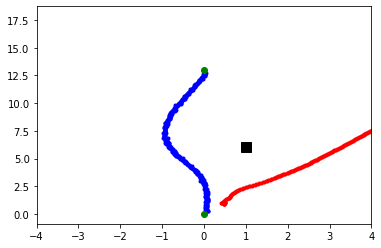

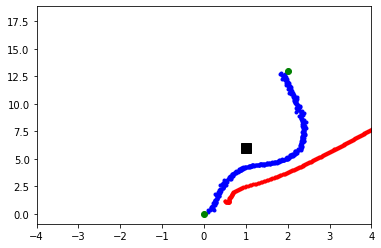

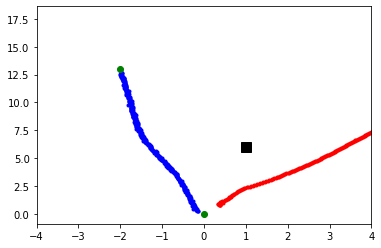

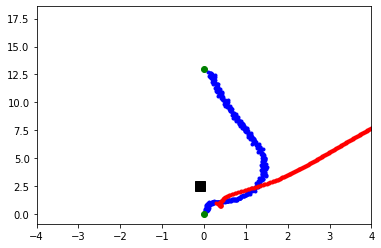

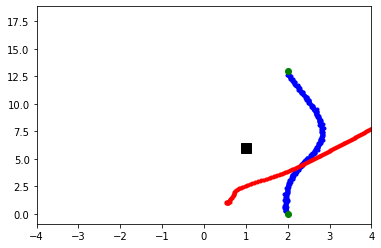

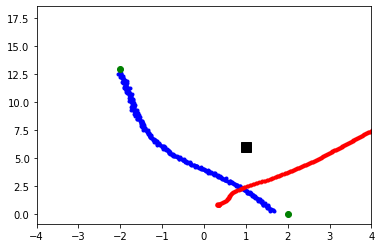

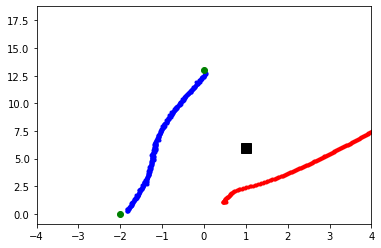

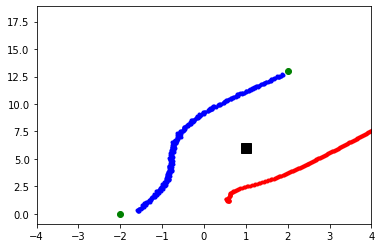

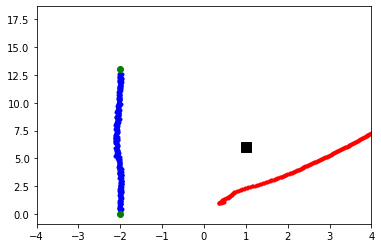

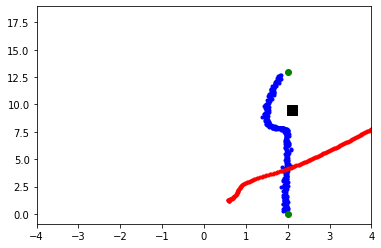

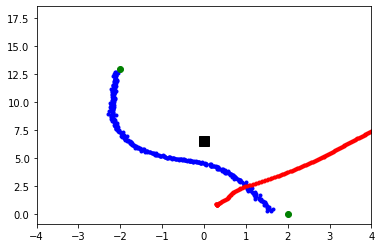

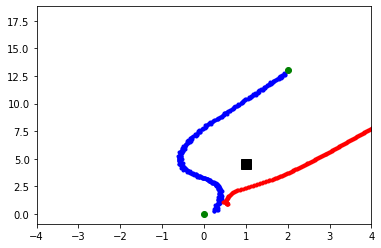

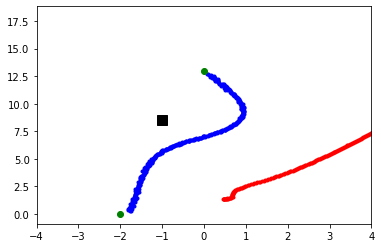

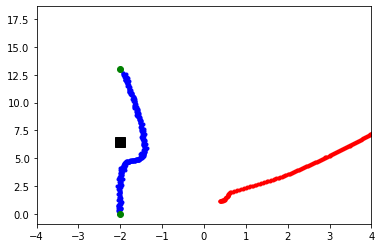

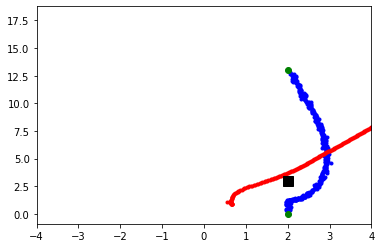

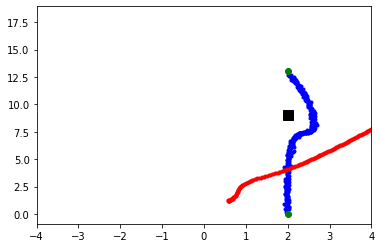

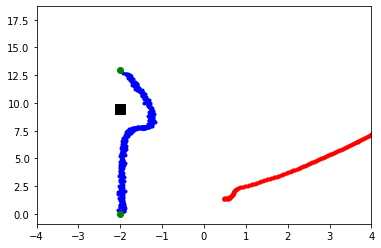

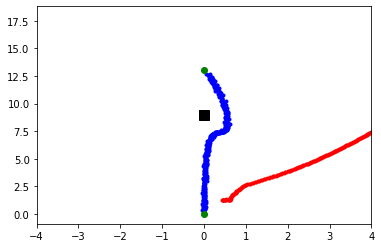

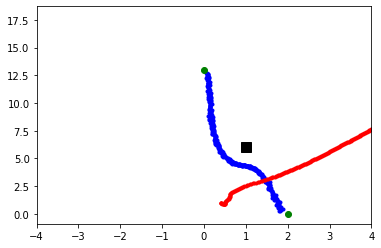

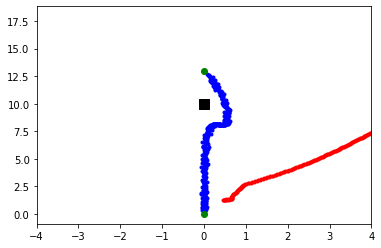

In [6]:
import matplotlib.pyplot as plt

for i in range(num_trajs):
    cnmp_x, cnmp_y = cnmp_trajectories[i][:, 0], cnmp_trajectories[i][:, 1]
    x, y = trajs_coords[i, :, 0], trajs_coords[i, :, 1]
    start_x, goal_x, obs_x, obs_y = float(config[i, 0]), float(config[i, 2]), float(config[i, 4]), float(config[i, 5])
    
    plt.xlim([-4, 4])
    plt.plot(x, y, "b.")
    plt.plot(cnmp_x, cnmp_y, "r.")
    plt.plot(start_x, 0, 'go')
    plt.plot(goal_x, 13, 'go')
    plt.plot(obs_x, obs_y, 'ks', markersize=10)  # 10 is not the actual size of the obstacle
    plt.show()
